In [1]:
from pylab import *
import numpy as np
%matplotlib widget

In [2]:
cd /data/craco/craco/SB070687/scans/00/20250210050845/nodes/01/


/CRACO/DATA_01/craco/SB070687/scans/00/20250210050845


/CRACO/SOFTWARE/ban115/venv310/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
pktd = np.load('cards/00/packets_cardid00_iblk000.npz')
pktd.keys()

KeysView(NpzFile 'cards/00/packets_cardid00_iblk000.npz' with keys: data, valid, fids)

In [4]:
pdata = pktd['data']
pdata.shape

(6, 144, 32)

In [5]:
pdata.dtype

dtype([('frame_id', '<u8'), ('bat', '<u8'), ('beam_number', 'u1'), ('sample_number', 'u1'), ('channel_number', 'u1'), ('fpga_id', 'u1'), ('nprod', '<u2'), ('flags', 'u1'), ('zero1', 'u1'), ('version', '<u4'), ('zero3', '<u4'), ('data', '<i2', (2, 465, 1, 2))])

In [6]:
pdata['data'].shape

(6, 144, 32, 2, 465, 1, 2)

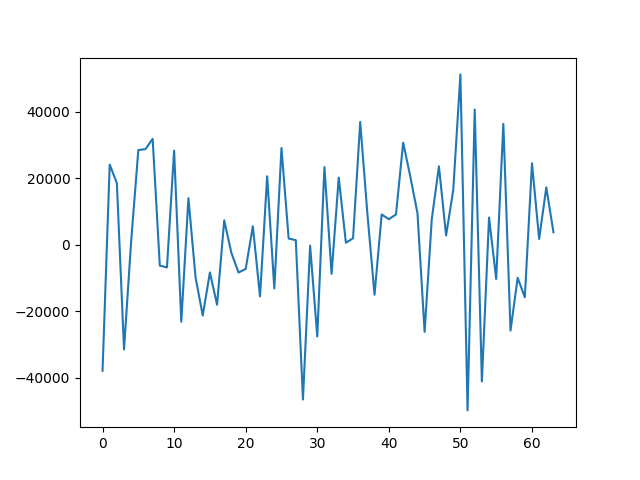

In [27]:
figure()
plot(pdata['data'][0,0,:,:,:,0,0].sum(axis=2).flatten())

In [8]:
ls 

b00.uvfits.an_table                flagging_stats_log_b00.csv
b00.uvfits.fq_table                flagging_stats_log_b18.csv
b00.uvfits.groupsize               ics_b00.fil
b00.uvfits.header                  ics_b18.fil
b00.uvfits.su_table                ics_scrunch_b00.fil
b18.uvfits.an_table                ics_scrunch_b18.fil
b18.uvfits.fq_table                ics_weights_b00.fil
b18.uvfits.groupsize               ics_weights_b18.fil
b18.uvfits.header                  pcbb00.fil
b18.uvfits.su_table                pcbb18.fil
beam00/                            pipeline_sink_dump.npz.npy
beam18/                            rank_000_trace.json
boxcar_hist_iblk0.npy              rank_001_trace.json
boxcar_hist_iblk1.npy              rank_002_trace.json
boxcar_hist_iblk2.npy              rank_003_trace.json
boxcar_hist_iblk3.npy              rank_073_trace.json
boxcar_hist_iblk4.npy              rank_074_trace.json
boxcar_hist_iblk5.npy              rank_075_trace.json
boxcar_hist_iblk6.npy  

In [9]:
cd beam00


/CRACO/DATA_01/craco/SB070687/scans/00/20250210050845/beam00


In [10]:
pd = np.load('pipeline_data_0.npy')

In [11]:
pd.dtype

dtype([('vis', '<c8', (253, 288, 256)), ('tf_weights', 'u1', (288, 256)), ('bl_weights', 'u1', (253,))])

In [12]:
pd['tf_weights'][0:10,0]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=uint8)

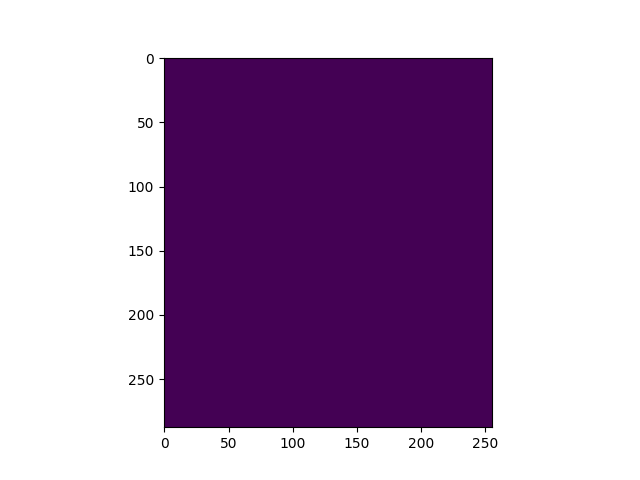

In [28]:
figure()
imshow(pd['tf_weights'])

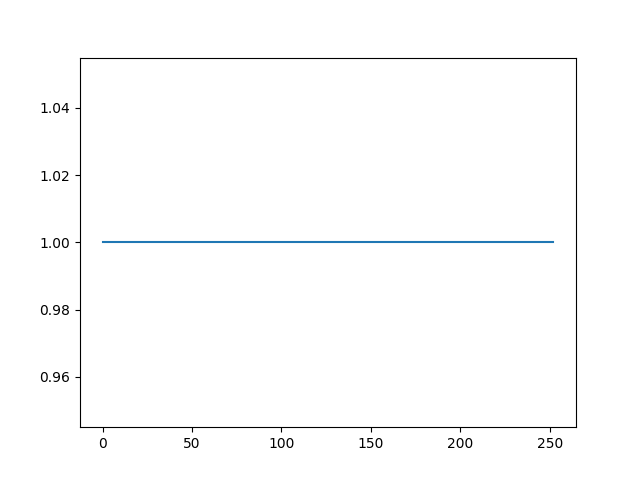

In [29]:
figure()
plot(pd['bl_weights'])

In [15]:
pd.dtype

dtype([('vis', '<c8', (253, 288, 256)), ('tf_weights', 'u1', (288, 256)), ('bl_weights', 'u1', (253,))])

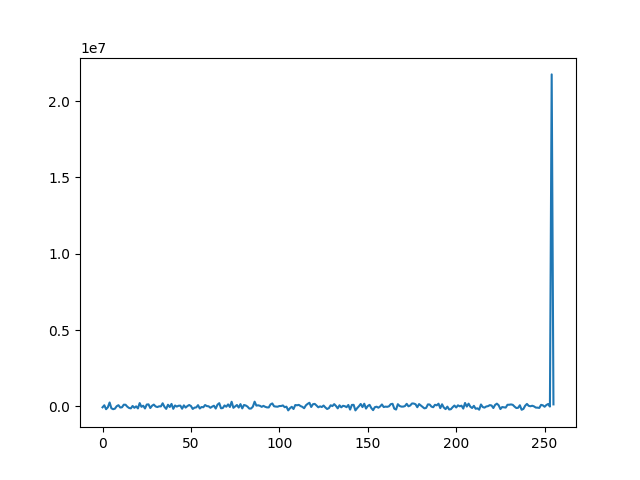

In [30]:
figure()
plot(pd['vis'].real.sum(axis=(0,1)))

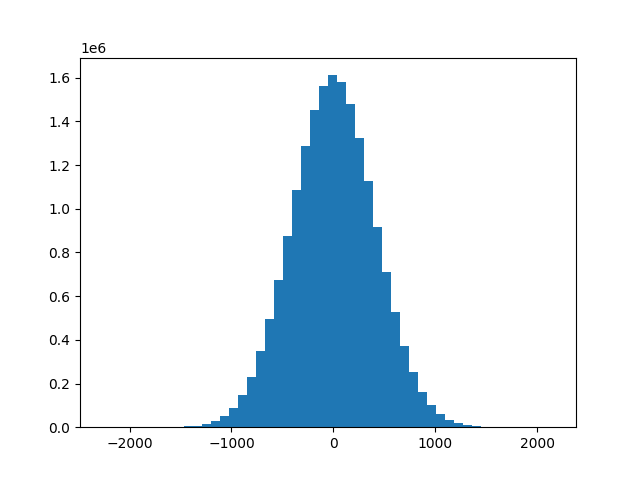

In [31]:
figure()
_ = hist(pd['vis'].real.flatten(), bins=50)

In [18]:
inp = np.load('input_iblk0.npy', allow_pickle=True)

In [19]:
(nuv, nc, nt) = inp.shape
inp.shape

(253, 288, 256)

In [20]:
print(inp.real.std(), inp.imag.std())

512.2171 511.7821


In [21]:
plot(inp.real.mean(axis=(0,1)))

In [88]:
bc = np.load('boxcar_hist_iblk2.npy')

In [89]:
bc[0,...].std(axis=(1,2))

array([197.05128818, 412.36854365, 133.87110417, 135.39926874,
       135.58643087, 133.61980683, 132.29471459])

In [90]:
np.all(bc == 0)

False

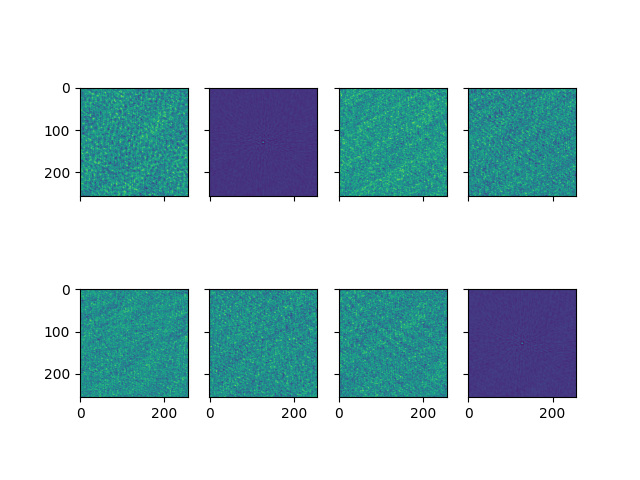

In [111]:
fig,ax = subplots(2,4, sharex=True, sharey=True)
for i in range(7):
    ax.flat[i].imshow(np.fft.fftshift(bc[0,i,:,:]))

ax.flat[7].imshow(np.fft.fftshift(bc[0,1,:,:] - bc[0,0,:,:]))

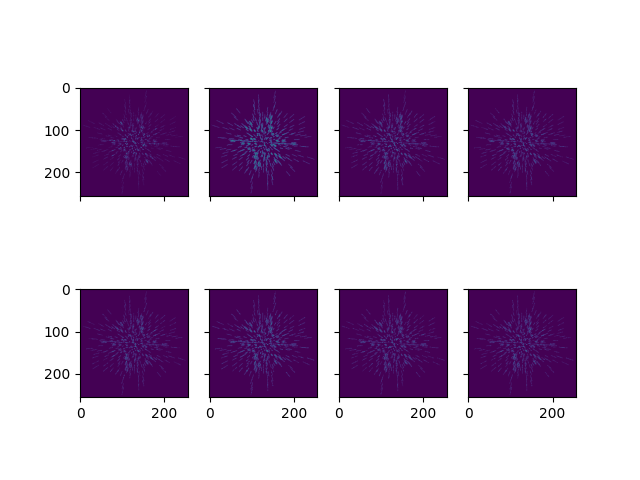

In [115]:
fig,ax = subplots(2,4, sharex=True, sharey=True)
for i in range(7):
    ax.flat[i].imshow(abs(np.fft.fftshift(np.fft.ifft2(bc[0,i,:,:]))))
    
ax.flat[7].imshow(abs(np.fft.fftshift(np.fft.ifft2(bc[0,5,:,:] - bc[0,4,:,:]))))

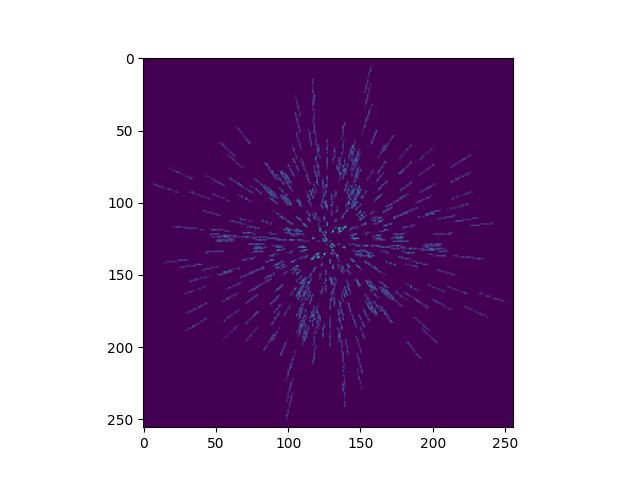

In [93]:
figure()
imshow(abs(np.fft.fftshift(np.fft.ifft2(bc[0,i,:,:]))))

In [94]:
ls plans

plan_iblk0.pkl    plan_iblk150.pkl  plan_iblk60.pkl
plan_iblk120.pkl  plan_iblk30.pkl   plan_iblk90.pkl


In [95]:
import pickle
plan = pickle.load(open('plans/plan_iblk0.pkl','rb'))

In [96]:
from craft import uvfits, craco_kernels, craco_plan
from craco import postprocess, uvfits_meta
import numpy as np
import matplotlib.pyplot as plt
from craft.cmdline import strrange

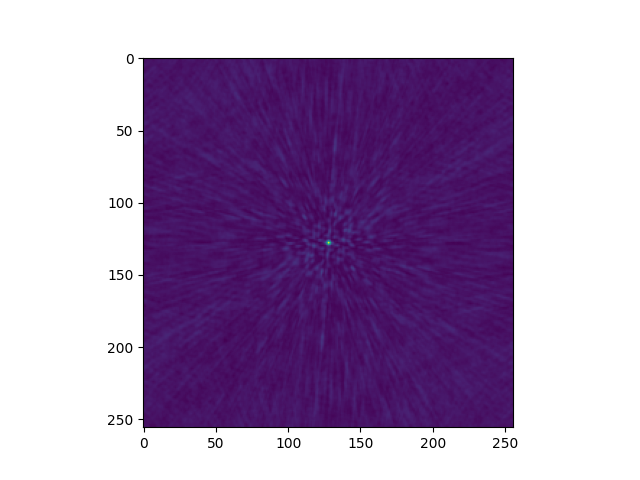

In [219]:
def dogrid(invis, plan,npix = 256):
    nuv = len(plan.uvcells)
    assert invis.ndim == 2   
    nt = block.shape[-1]
    g = np.zeros((npix, npix), dtype=np.complex64)
    for iuv in range(nuv):
        cell = plan.uvcells[iuv]
        vpix, upix = cell.uvpix # WARNING: Transposing in grid. NO tsure why I have to do this.
        bl_idx = plan.baseline_order.index(cell.blid)
        v1 = invis[ bl_idx, cell.chan_slice].sum(axis=0)
        #print(iuv, cell.blid, bl_idx, cell, v1.shape)
        if abs(v1) == 0:
            print(f'v1=0 for blidx={bl_idx} iuv={iuv}, uv={vpix},{upix}')

        v2 = 0
        g[vpix, upix] += v1 + v2
        g[-vpix, -upix] += np.conj(v1) - np.conj(v2)
    return g

figure()
# (nuv, nc, nt) = inp.shape
imshow(np.fft.fftshift(np.fft.fft2(dogrid(inp[...,-2], plan))).real)


In [220]:
iuv = 3
plan.uvcells[iuv]

Cell blid=5141.0 chan=256-287 freq=1917.67-1948.67 uvpix=(14, 1) upper_idx=269 uvpix_upper=(14, 1)

In [221]:
cell.chan_slice

slice(256, 288, None)

In [222]:
inp[cell.chan_slice, 243, -2]

array([], dtype=complex64)

In [223]:
inp.shape

(253, 288, 256)

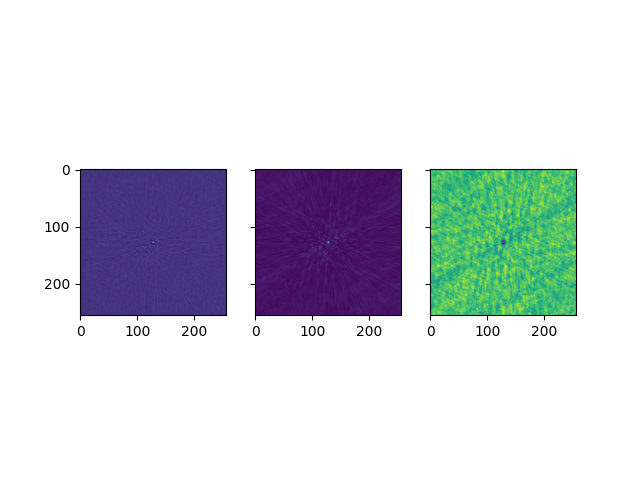

In [224]:
i1 = np.fft.fftshift(bc[0,1,:,:])
i2 = np.fft.fftshift(np.fft.fft2(dogrid(inp[...,-2], plan))).real
fig,ax = subplots(1,3, sharex=True, sharey=True)
ax[0].imshow(i1)
ax[1].imshow(i2)
ax[2].imshow(i1/i1.max() - i2/i2.max())

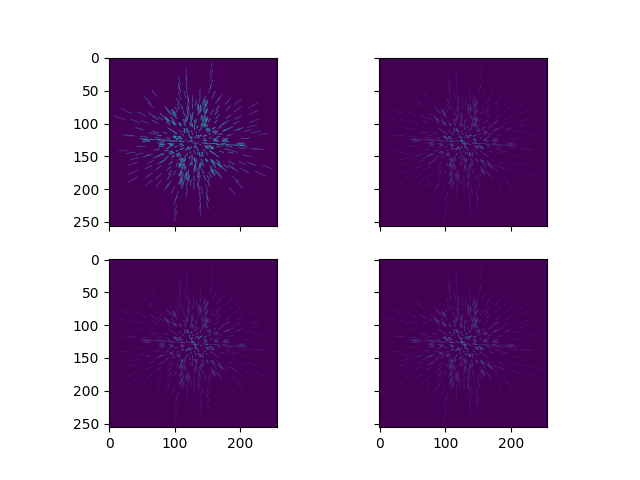

In [229]:
u1 = np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(i1/i1.max())))
#u2 = np.fft.fftshift(dogrid(inp[...,-2], plan))
u2 = np.fft.fftshift(dogrid(inp[...,-2], plan))
u3 = np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(i2/i2.max())))
a1 = abs(u1)
a2 = abs(u2)
a3 = abs(u3)
fig,ax = subplots(2,2, sharex=True, sharey=True)
ax = ax.flat
ax[0].imshow(a1)
ax[1].imshow(a2)
ax[2].imshow(a3)
ax[3].imshow(abs(u2 - u1))

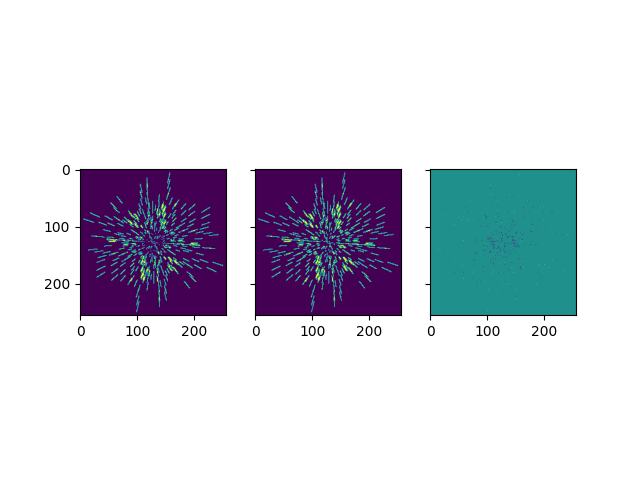

In [232]:
m1 = u1 > 1e-6
m2 = u2 > 1e-7
maskdiff = m1.astype(int) - m2.astype(int)
fig,ax = subplots(1,3, sharex=True, sharey=True)
ax[0].imshow(m1)
ax[1].imshow(m2)
ax[2].imshow(maskdiff)


In [233]:

print(f'm1={sum(m1)} m2={sum(m2)} diff={sum(abs(maskdiff))}')

m1=4506 m2=4718 diff=344
